In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline 

In [3]:
pd.set_option('display.max_rows', 100)

## Load Data

In [4]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint16,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [5]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint16,
    'department': np.str},
    usecols=['department_id', 'department'])

In [6]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [7]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [8]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.uint16,
    'order_dow': np.uint16,
    'order_hour_of_day': np.uint8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [9]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint16,
        'department_id': np.uint16},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

##  Genarating Features

In [9]:
orders['days_since_first_order'] = orders.groupby('user_id')['days_since_prior_order'].cumsum()

In [10]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,NaN
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


In [11]:
orders.days_since_first_order.fillna(0, inplace = True)

In [12]:
order_products_prior.shape

(32434489, 4)

In [13]:
priordf = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')

In [14]:
priordf.shape

(32434489, 11)

In [15]:
priordf.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2,33120,1,1,202279,prior,3,5,9,8.0,28.0
1,2,28985,2,1,202279,prior,3,5,9,8.0,28.0
2,2,9327,3,0,202279,prior,3,5,9,8.0,28.0
3,2,45918,4,1,202279,prior,3,5,9,8.0,28.0
4,2,30035,5,0,202279,prior,3,5,9,8.0,28.0


In [16]:
priordf['days_since_first_order'].fillna(0, inplace=True)

In [17]:
priordf.sort_values(['user_id', 'product_id','order_number'], inplace = True)

In [18]:
priordf['days_since_prior_product_purchase'] = priordf.groupby(['user_id', 'product_id'])['days_since_first_order'].transform(lambda x: x.diff())

In [19]:
#pickle.dump(priordf, open('data/pickle_files/priordf.p', 'wb'))

In [14]:
priordf = pickle.load(open('data/pickle_files/priordf.p', 'rb'))

In [15]:
#user_info

In [16]:
user_info = pd.DataFrame()
user_info['user_order_num'] = priordf.groupby('user_id')['order_id'].nunique().astype(np.uint16)

In [17]:
user_info['user_order_interval_mean'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['days_since_prior_order'].mean()).groupby(['user_id'])['days_since_prior_order'].mean().astype(np.float32)

In [18]:
user_info['user_order_interval_std'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['days_since_prior_order'].mean()).groupby(['user_id'])['days_since_prior_order'].std().astype(np.float32)

In [19]:
user_info['user_basket_size_mean'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['product_id'].count()).groupby('user_id')['product_id'].mean().astype(np.float32)

In [20]:
user_info['user_basket_size_std'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['product_id'].count()).groupby('user_id')['product_id'].std().astype(np.float32)

In [21]:
user_info['user_history'] = priordf.groupby('user_id')['days_since_first_order'].max().astype(np.uint16)

In [22]:
user_info.reset_index(inplace = True)

In [23]:
user_info.head()

,user_id,user_order_num,user_order_interval_mean,user_order_interval_std,user_basket_size_mean,user_basket_size_std,user_history
0,1,10,19.555555,9.395625,5.900000,1.523884,176
1,2,14,15.230769,9.867064,13.928572,5.717238,198
2,3,12,12.090909,5.375026,7.333333,2.103388,133
3,4,5,13.750000,9.500000,3.600000,2.073644,55
4,5,4,13.333333,4.932883,9.250000,3.095696,40


In [24]:
#pickle.dump(user_info, open('data/pickle_files/user_info.p', 'wb'))

In [ ]:
#product_info

In [25]:
product_info = pd.DataFrame()

In [26]:
product_info['product_user_num'] = priordf.groupby(['product_id'])['user_id'].nunique().astype(np.uint32)

In [27]:
product_info['product_order_num'] = priordf.groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [28]:
product_info['product_order_interval_mean'] = priordf.groupby(['product_id'])['days_since_prior_product_purchase'].mean().astype(np.float32)

In [29]:
product_info['product_order_interval_std'] = priordf.groupby(['product_id'])['days_since_prior_product_purchase'].std().astype(np.float32)

In [30]:
product_info['product_reorder_num'] = priordf[priordf.reordered == 1].groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [31]:
product_info['product_reorder_num'].fillna(0, inplace = True)

In [32]:
product_info['product_reorder_user_num'] = priordf[priordf.reordered == 1].groupby(['product_id'])['user_id'].nunique().astype(np.uint32)

In [33]:
product_info['product_reorder_user_num'].fillna(0, inplace = True)

In [34]:
product_info['product_reorder_ratio'] = product_info['product_reorder_num']/product_info['product_order_num']

In [35]:
product_info['product_reorder_user_ratio'] = product_info['product_reorder_user_num']/product_info['product_user_num']

In [36]:
product_info['product_add_to_cart_order_mean'] = priordf.groupby(['product_id'])['add_to_cart_order'].mean().astype(np.float32)

In [37]:
product_info['product_add_to_cart_order_std'] = priordf.groupby(['product_id'])['add_to_cart_order'].std().astype(np.float32)

In [38]:
product_info.reset_index(inplace = True)

In [39]:
product_info = pd.merge(product_info, products, on = 'product_id', how = 'left')

In [11]:
product_info['product_order_interval_mean_NaN'] = product_info.product_order_interval_mean.isnull()
product_info['product_order_interval_mean_NaN'].replace([False, True], [0, 1], inplace = True)
product_info['product_order_interval_std_NaN'] = product_info.product_order_interval_std.isnull()
product_info['product_order_interval_std_NaN'].replace([False, True], [0, 1], inplace = True)
product_info['product_add_to_cart_order_std_NaN'] = product_info.product_add_to_cart_order_std.isnull()
product_info['product_add_to_cart_order_std_NaN'].replace([False, True], [0, 1], inplace = True)

In [ ]:
product_info.fillna(product_info.mean(), inplace = True)

In [13]:
product_info.head()

,product_id,product_user_num,product_order_num,product_order_interval_mean,product_order_interval_std,product_reorder_num,product_reorder_user_num,product_reorder_ratio,product_reorder_user_ratio,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_name,aisle_id,department_id,product_order_interval_mean_NaN,product_order_interval_std_NaN,product_add_to_cart_order_std_NaN
0,1,716,1852,27.961267,37.873127,1136.0,276.0,0.613391,0.385475,5.801836,5.575389,Chocolate Sandwich Cookies,61,19,0,0,0
1,2,78,90,50.166668,52.135895,12.0,8.0,0.133333,0.102564,9.888889,7.821671,All-Seasons Salt,104,13,0,0,0
2,3,74,277,19.369457,24.833035,203.0,36.0,0.732852,0.486486,6.415163,6.472701,Robust Golden Unsweetened Oolong Tea,94,7,0,0,0
3,4,182,329,31.707483,28.790031,147.0,64.0,0.446809,0.351648,9.507599,6.861485,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0,0,0
4,5,6,15,34.888889,36.511795,9.0,4.0,0.600000,0.666667,6.466667,3.563038,Green Chile Anytime Sauce,5,13,0,0,0


In [14]:
#pickle.dump(product_info, open('data/pickle_files/product_info.p', 'wb'))

In [11]:
#user_product_info

In [42]:
user_product_info = pd.DataFrame(priordf.reset_index().groupby(['user_id', 'product_id'])['order_id'].nunique())

In [43]:
user_product_info.rename(columns = {'order_id': 'user_product_order_num'}, inplace = True)

In [44]:
user_product_info['user_product_last_purchase_day'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_first_order'].max().astype(np.uint32)

In [45]:
user_product_info.rename(columns = {'user_product_order_interval': 'user_product_order_interval_mean'}, inplace = True)

In [46]:
user_product_info['user_product_order_interval_mean'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_prior_product_purchase'].mean()

In [47]:
user_product_info['user_product_order_interval_std'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_prior_product_purchase'].std()

In [48]:
user_product_info['user_product_rank'] = user_product_info.groupby('user_id')['user_product_order_num'].rank(ascending=False)

In [49]:
user_product_info['user_product_add_order_mean'] = priordf.reset_index().groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().astype(np.float32)

In [50]:
user_product_info['user_product_add_order_std'] = priordf.reset_index().groupby(['user_id', 'product_id'])['add_to_cart_order'].std().astype(np.float32)

In [51]:
user_product_info = pd.merge(pd.DataFrame(user_product_info).reset_index(), user_info.reset_index()[['user_id', 'user_order_num']], on='user_id', how = 'left')

In [52]:
user_product_info['user_product_reorder_ratio'] = user_product_info.user_product_order_num/user_product_info.user_order_num

In [53]:
user_product_info.drop('user_order_num', axis = 1, inplace = True)

In [5]:
user_product_info['user_product_order_interval_mean_NaN'] = user_product_info.user_product_order_interval_mean.isnull()
user_product_info['user_product_order_interval_mean_NaN'].replace([False, True], [0, 1], inplace = True)
user_product_info['user_product_order_interval_std_NaN'] = user_product_info.user_product_order_interval_std.isnull()
user_product_info['user_product_order_interval_std_NaN'].replace([False, True], [0, 1], inplace = True)
user_product_info['user_product_add_order_std_NaN'] = user_product_info.user_product_add_order_std.isnull()
user_product_info['user_product_add_order_std_NaN'].replace([False, True], [0, 1], inplace = True)

In [ ]:
user_product_info.fillna(user_product_info.mean(), inplace = True)

In [9]:
user_product_info.head()

,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,user_product_reorder_ratio,user_product_order_interval_mean_NaN,user_product_order_interval_std_NaN,user_product_add_order_std_NaN
0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,1.0,0,0,0
1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,0.9,0,0,0
2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,0.1,1,1,1
3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,1.0,0,0,0
4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525,0.3,0,0,0


In [10]:
#pickle.dump(user_product_info, open('data/pickle_files/user_product_info.p', 'wb'))

In [64]:
#ordertime_info

In [56]:
priordf.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,days_since_prior_product_purchase
24076664,2539329,196,1,0,1,prior,1,2,8,NaN,0.0,NaN
22742744,2398795,196,1,1,1,prior,2,3,7,15.0,15.0,15.0
4488095,473747,196,1,1,1,prior,3,3,12,21.0,36.0,21.0
21376074,2254736,196,1,1,1,prior,4,4,7,29.0,65.0,29.0
4089398,431534,196,1,1,1,prior,5,4,15,28.0,93.0,28.0


In [57]:
ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique())

In [58]:
ordertime_info.rename(columns = {'order_id': 'ordertime_order_num'}, inplace = True)

In [59]:
ordertime_info.reset_index(inplace=True)

In [60]:
ordertime_info.head()

,order_dow,order_hour_of_day,ordertime_order_num
0,0,0,3692
1,0,1,2235
2,0,2,1299
3,0,3,888
4,0,4,750


In [61]:
#pickle.dump(ordertime_info, open('data/pickle_files/ordertime_info.p', 'wb'))

In [62]:
user_ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['user_id','order_dow', 'order_hour_of_day'])['order_id'].nunique())

In [63]:
user_ordertime_info.rename(columns = {'order_id': 'user_ordertime_order_num'}, inplace = True)
user_ordertime_info.reset_index(inplace=True)

In [64]:
user_ordertime_info.head()

,user_id,order_dow,order_hour_of_day,user_ordertime_order_num
0,1,1,9,1
1,1,1,14,1
2,1,1,16,1
3,1,2,7,1
4,1,2,8,1


In [65]:
#pickle.dump(user_ordertime_info, open('data/pickle_files/user_ordertime_info.p', 'wb'))

In [75]:
product_ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['product_id','order_dow', 'order_hour_of_day'])['order_id'].nunique())

In [76]:
product_ordertime_info.rename(columns = {'order_id': 'product_ordertime_order_num'}, inplace = True)
product_ordertime_info.reset_index(inplace=True)

In [77]:
product_ordertime_info.head()

,product_id,order_dow,order_hour_of_day,product_ordertime_order_num
0,1,0,0,1
1,1,0,1,1
2,1,0,5,1
3,1,0,6,1
4,1,0,7,4


In [78]:
#pickle.dump(product_ordertime_info, open('data/pickle_files/product_ordertime_info.p', 'wb'))

In [76]:
#aisle_info

In [77]:
product_info.head()

,product_id,product_user_num,product_order_num,product_order_interval_mean,product_order_interval_std,product_reorder_num,product_reorder_user_num,product_reorder_ratio,product_reorder_user_ratio,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_name,aisle_id,department_id
0,1,716,1852,27.961267,37.873127,1136.0,276.0,0.613391,0.385475,5.801836,5.575389,Chocolate Sandwich Cookies,61,19
1,2,78,90,50.166668,52.135895,12.0,8.0,0.133333,0.102564,9.888889,7.821671,All-Seasons Salt,104,13
2,3,74,277,19.369457,24.833035,203.0,36.0,0.732852,0.486486,6.415163,6.472701,Robust Golden Unsweetened Oolong Tea,94,7
3,4,182,329,31.707483,28.790031,147.0,64.0,0.446809,0.351648,9.507599,6.861485,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,6,15,34.888889,36.511795,9.0,4.0,0.600000,0.666667,6.466667,3.563038,Green Chile Anytime Sauce,5,13


In [66]:
agg_to_aisle = {
    'product_user_num':['sum','mean','std'], 
    'product_order_num':['sum', 'mean', 'std'], 
    'product_order_interval_mean':['mean', 'std'],
    'product_reorder_num': ['sum','mean','std'],
    'product_reorder_user_num': ['sum','mean','std'],
    'product_add_to_cart_order_mean': ['mean','std'],
    'department_id': ['mean']
}

In [67]:
aisle_info = product_info.groupby('aisle_id').agg(agg_to_aisle)

In [68]:
aisle_info.columns = ["_".join(x) for x in aisle_info.columns.ravel()]

In [69]:
aisle_info.shape

(134, 17)

In [70]:
aisle_info.rename(columns = {'product_user_num_sum': 'aisle_prod_user_num_sum', 'product_user_num_mean': 'aisle_prod_user_num_mean', 'product_user_num_std': 'aisle_prod_user_num_std', 'product_order_num_sum': 'aisle_prod_order_num_sum', 'product_order_num_mean': 'aisle_prod_order_num_mean', 'product_order_num_std': 'aisle_prod_order_num_std', 'product_order_interval_mean_mean': 'aisle_prod_order_interval_mean_mean', 'product_order_interval_mean_std': 'aisle_prod_order_interval_mean_std', 'product_reorder_num_sum': 'aisle_prod_reorder_num_sum',
'product_reorder_num_mean': 'aisle_prod_reorder_num_mean', 'product_reorder_num_std': 'aisle_prod_reorder_num_std', 'product_reorder_user_num_sum': 'aisle_prod_reorder_user_num_sum', 'product_reorder_user_num_mean': 'aisle_prod_reorder_user_num_mean', 'product_reorder_user_num_std': 'aisle_prod_reorder_user_num_std', 'product_add_to_cart_order_mean_mean': 'aisle_prod_add_to_cart_order_mean', 'product_add_to_cart_order_mean_std': 'aisle_prod_add_to_cart_order_std', 'department_id_mean': 'department_id'}, inplace=True)

In [71]:
aisle_info['aisle_reorder_ratio'] = aisle_info.aisle_prod_reorder_num_mean/aisle_info.aisle_prod_order_num_mean

In [72]:
aisle_info['aisle_user_reorder_ratio'] = aisle_info.aisle_prod_reorder_user_num_mean/aisle_info.aisle_prod_user_num_mean

In [73]:
aisle_info.reset_index(inplace = True)

In [74]:
aisle_info.head()

,aisle_id,aisle_prod_user_num_sum,aisle_prod_user_num_mean,aisle_prod_user_num_std,aisle_prod_order_num_sum,aisle_prod_order_num_mean,aisle_prod_order_num_std,aisle_prod_order_interval_mean_mean,aisle_prod_order_interval_mean_std,aisle_prod_reorder_num_sum,aisle_prod_reorder_num_mean,aisle_prod_reorder_num_std,aisle_prod_reorder_user_num_sum,aisle_prod_reorder_user_num_mean,aisle_prod_reorder_user_num_std,aisle_prod_add_to_cart_order_mean,aisle_prod_add_to_cart_order_std,department_id,aisle_reorder_ratio,aisle_user_reorder_ratio
0,1,29016,198.739726,327.565736,71928,492.657534,903.061677,27.059513,13.772337,42912.0,293.917808,606.896350,11534.0,79.000000,142.516835,8.818574,1.806635,20,0.596597,0.397505
1,2,42126,155.446494,407.096189,82491,304.394834,839.887252,36.342415,17.781334,40365.0,148.948339,451.846038,13739.0,50.697417,147.091319,9.358910,2.217766,16,0.489326,0.326141
2,3,183464,220.509615,446.923550,456386,548.540865,1193.136418,26.012691,14.447985,272922.0,328.031250,756.991138,75508.0,90.754808,199.192987,9.891664,2.654259,19,0.598007,0.411568
3,4,102444,188.662983,482.255550,200687,369.589319,1022.140681,36.945961,16.613544,98243.0,180.926335,547.872967,35470.0,65.322284,186.106379,10.449979,2.380114,9,0.489533,0.346238
4,5,44968,109.946210,389.037396,62510,152.836186,535.526065,48.310493,28.437979,17542.0,42.889976,151.139042,9067.0,22.168704,79.528503,10.370530,2.503755,13,0.280627,0.201632


In [79]:
#pickle.dump(aisle_info, open('data/pickle_files/aisle_info.p', 'wb'))

In [80]:
agg_to_department = {
    'aisle_prod_user_num_sum':['sum'], 
    'aisle_prod_user_num_mean':['mean', 'std'], 
    'aisle_prod_order_num_sum':['sum'],
    'aisle_prod_order_num_mean': ['mean','std'],
    'aisle_prod_add_to_cart_order_mean': ['mean','std'],
    'aisle_prod_reorder_num_sum': ['sum'],
    'aisle_prod_reorder_num_mean': ['mean', 'std'],
    'aisle_prod_reorder_user_num_sum': ['sum'],
    'aisle_prod_reorder_user_num_mean': ['mean', 'std'],
    'aisle_prod_add_to_cart_order_mean': ['mean', 'std']
}

In [81]:
department_info = aisle_info.groupby('department_id').agg(agg_to_department)

In [82]:
department_info.columns = ["_".join(x) for x in department_info.columns.ravel()]

In [83]:
department_info.rename(columns = {'aisle_prod_user_num_sum_sum': 'department_prod_user_num_sum', 'aisle_prod_user_num_mean_mean': 'department_prod_user_num_mean', 'aisle_prod_user_num_mean_std': 'department_prod_user_num_std', 'aisle_prod_order_num_sum_sum': 'department_prod_order_num_sum', 'aisle_prod_order_num_mean_mean': 'department_prod_order_num_mean', 'aisle_prod_order_num_mean_std': 'department_prod_order_num_std', 'aisle_prod_add_to_cart_order_mean_mean': 'department_prod_add_to_cart_order_mean', 'aisle_prod_add_to_cart_order_mean_std': 'department_prod_add_to_cart_order_std', 'aisle_prod_reorder_num_sum_sum': 'department_prod_reorder_num_sum', 'aisle_prod_reorder_num_mean_mean': 'department_prod_reorder_num_mean', 'aisle_prod_reorder_num_mean_std': 'department_prod_reorder_num_std', 'aisle_prod_reorder_user_num_sum_sum': 'department_prod_reorder_user_num_sum', 'aisle_prod_reorder_user_num_mean_mean': 'department_prod_reorder_user_num_mean', 'aisle_prod_reorder_user_num_mean_std': 'department_prod_reorder_user_num_std'}, inplace=True)

In [84]:
department_info.reset_index(inplace=True)

In [ ]:
department_info.fillna(department_info.mean(), inplace = True)

In [16]:
department_info.head()

,department_id,department_prod_user_num_sum,department_prod_user_num_mean,department_prod_user_num_std,department_prod_order_num_sum,department_prod_order_num_mean,department_prod_order_num_std,department_prod_add_to_cart_order_mean,department_prod_add_to_cart_order_std,department_prod_reorder_num_sum,department_prod_reorder_num_mean,department_prod_reorder_num_std,department_prod_reorder_user_num_sum,department_prod_reorder_user_num_mean,department_prod_reorder_user_num_std
0,1,1024542,236.481141,157.357773,2236432,521.277099,357.891529,9.448644,0.410135,1211890.0,284.795958,203.467608,384906.0,89.447962,62.441625
1,2,21485,39.206204,140.801184,36291,66.224453,440.523334,8.194178,0.660021,14806.0,27.018248,310.080199,5242.0,9.565693,68.354231
2,3,437599,284.799407,133.339532,1176787,731.722032,402.974496,8.688531,0.679768,739188.0,446.922625,279.338436,191404.0,120.370615,64.988071
3,4,3318581,2190.172202,683.524710,9479291,6286.046039,2799.902559,8.410426,1.865486,6160710.0,4095.873837,2222.922021,1598097.0,1047.023084,403.342103
4,5,66101,64.488959,8.432910,153696,149.577623,35.271070,6.270197,0.480617,87595.0,85.088664,27.718302,24289.0,23.233552,5.400507


In [17]:
#pickle.dump(department_info, open('data/pickle_files/department_info.p', 'wb'))

## Baseline

In [158]:
master_prior_df = pd.merge(user_product_info.reset_index(), user_info.reset_index(), on='user_id', how='left')

In [159]:
master_prior_df = pd.merge(master_prior_df, product_info.reset_index(), on='product_id', how = 'left')

In [161]:
#pickle.dump(master_prior_df, open('data/master_prior_df.p', 'wb'))

In [162]:
train_users = orders[orders.eval_set == 'train'].user_id

In [163]:
train_users.head()

10    1
25    2
49    5
74    7
78    8
Name: user_id, dtype: uint32

In [164]:
traindf = master_prior_df[master_prior_df.user_id.isin(train_users)]

In [165]:
traindf = pd.merge(traindf, orders[orders.eval_set == 'train'], on='user_id', how = 'left')

In [166]:
traindf = pd.merge(traindf, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [167]:
traindf.columns

Index(['user_id', 'product_id', 'user_product_purchase_count',
       'user_product_last_purchase_day',
       'user_product_average_purchase_interval', 'user_product_rank',
       'user_product_avg_add_order', 'user_count_of_order',
       'user_average_order_interval', 'user_average_basket_size',
       'product_user_count', 'product_order_count',
       'product_average_purchase_interval', 'product_reorder_count',
       'reorder_ratio', 'average_add_to_cart_order', 'order_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_order', 'reordered'],
      dtype='object')

In [168]:
traindf.reordered.fillna(0, inplace = True)

In [169]:
traindf.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [170]:
traindf.rename(columns = {'reordered': 'y'}, inplace = True)

In [171]:
traindf.columns

Index(['user_id', 'product_id', 'user_product_purchase_count',
       'user_product_last_purchase_day',
       'user_product_average_purchase_interval', 'user_product_rank',
       'user_product_avg_add_order', 'user_count_of_order',
       'user_average_order_interval', 'user_average_basket_size',
       'product_user_count', 'product_order_count',
       'product_average_purchase_interval', 'product_reorder_count',
       'reorder_ratio', 'average_add_to_cart_order', 'order_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_order', 'y'],
      dtype='object')

In [172]:
traindf.head()

,user_id,product_id,user_product_purchase_count,user_product_last_purchase_day,user_product_average_purchase_interval,user_product_rank,user_product_avg_add_order,user_count_of_order,user_average_order_interval,user_average_basket_size,...,reorder_ratio,average_add_to_cart_order,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y
0,1,196,10,176,19.555555,1.5,1,10,19.555555,5.9,...,0.776480,3,1187899,train,11,4,8,14.0,1.0,1.0
1,1,10258,9,176,20.125000,3.0,3,10,19.555555,5.9,...,0.713772,4,1187899,train,11,4,8,14.0,6.0,1.0
2,1,10326,1,93,NaN,14.5,5,10,19.555555,5.9,...,0.652009,4,1187899,train,11,4,8,14.0,NaN,0.0
3,1,12427,10,176,19.555555,1.5,3,10,19.555555,5.9,...,0.740735,4,1187899,train,11,4,8,14.0,NaN,0.0
4,1,13032,3,176,80.500000,5.5,6,10,19.555555,5.9,...,0.657158,5,1187899,train,11,4,8,14.0,7.0,1.0


In [173]:
traindf['y_baseline'] = np.where(traindf.user_product_rank < traindf.user_average_basket_size, 1, 0)

In [174]:
traindf.head()

,user_id,product_id,user_product_purchase_count,user_product_last_purchase_day,user_product_average_purchase_interval,user_product_rank,user_product_avg_add_order,user_count_of_order,user_average_order_interval,user_average_basket_size,...,average_add_to_cart_order,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y,y_predicted
0,1,196,10,176,19.555555,1.5,1,10,19.555555,5.9,...,3,1187899,train,11,4,8,14.0,1.0,1.0,1
1,1,10258,9,176,20.125000,3.0,3,10,19.555555,5.9,...,4,1187899,train,11,4,8,14.0,6.0,1.0,1
2,1,10326,1,93,NaN,14.5,5,10,19.555555,5.9,...,4,1187899,train,11,4,8,14.0,NaN,0.0,0
3,1,12427,10,176,19.555555,1.5,3,10,19.555555,5.9,...,4,1187899,train,11,4,8,14.0,NaN,0.0,1
4,1,13032,3,176,80.500000,5.5,6,10,19.555555,5.9,...,5,1187899,train,11,4,8,14.0,7.0,1.0,1


In [175]:
from sklearn.metrics import f1_score

In [176]:
f1_score(traindf.y, traindf.y_predicted)

0.37379894766909949

## Models!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline 

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, KFold, GridSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc,accuracy_score,recall_score,precision_score,f1_score
from xgboost import XGBClassifier

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint16,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [5]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint16,
    'department': np.str},
    usecols=['department_id', 'department'])

In [6]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [7]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [8]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.uint16,
    'order_dow': np.uint16,
    'order_hour_of_day': np.uint8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [9]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint16,
        'department_id': np.uint16},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

In [10]:
priordf = pickle.load(open('data/pickle_files/priordf.p', 'rb'))
user_info = pickle.load(open('data/pickle_files/user_info.p', 'rb'))
product_info = pickle.load(open('data/pickle_files/product_info.p', 'rb'))
user_product_info = pickle.load(open('data/pickle_files/user_product_info.p', 'rb'))
ordertime_info = pickle.load(open('data/pickle_files/ordertime_info.p', 'rb'))
user_ordertime_info = pickle.load(open('data/pickle_files/user_ordertime_info.p', 'rb'))
product_ordertime_info = pickle.load(open('data/pickle_files/product_ordertime_info.p', 'rb'))
aisle_info = pickle.load(open('data/pickle_files/aisle_info.p', 'rb'))
department_info = pickle.load(open('data/pickle_files/department_info.p', 'rb'))

In [11]:
master_prior_df = pd.merge(user_product_info, user_info, on = 'user_id', how = 'left')

In [12]:
master_prior_df = pd.merge(master_prior_df, product_info, on = 'product_id', how = 'left')

In [13]:
master_prior_df = pd.merge(master_prior_df, aisle_info, on = 'aisle_id', how = 'left', suffixes=('', '_y'))

In [14]:
master_prior_df.drop('department_id_y', axis = 1, inplace=True)

In [15]:
master_prior_df = pd.merge(master_prior_df, department_info, on = 'department_id', how = 'left', suffixes=('', '_y'))

In [16]:
train_users = orders[orders.eval_set == 'train'].user_id

In [17]:
train_df = master_prior_df[master_prior_df.user_id.isin(train_users)]

In [18]:
train_df.head()

,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,user_product_reorder_ratio,user_product_order_interval_mean_NaN,user_product_order_interval_std_NaN,user_product_add_order_std_NaN,user_order_num,user_order_interval_mean,user_order_interval_std,user_basket_size_mean,user_basket_size_std,user_history,product_user_num,product_order_num,product_order_interval_mean,product_order_interval_std,product_reorder_num,product_reorder_user_num,product_reorder_ratio,product_reorder_user_ratio,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_name,aisle_id,department_id,product_order_interval_mean_NaN,product_order_interval_std_NaN,product_add_to_cart_order_std_NaN,aisle_prod_user_num_sum,aisle_prod_user_num_mean,aisle_prod_user_num_std,aisle_prod_order_num_sum,aisle_prod_order_num_mean,aisle_prod_order_num_std,aisle_prod_order_interval_mean_mean,aisle_prod_order_interval_mean_std,aisle_prod_reorder_num_sum,aisle_prod_reorder_num_mean,aisle_prod_reorder_num_std,aisle_prod_reorder_user_num_sum,aisle_prod_reorder_user_num_mean,aisle_prod_reorder_user_num_std,aisle_prod_add_to_cart_order_mean,aisle_prod_add_to_cart_order_std,aisle_reorder_ratio,aisle_user_reorder_ratio,department_prod_user_num_sum,department_prod_user_num_mean,department_prod_user_num_std,department_prod_order_num_sum,department_prod_order_num_mean,department_prod_order_num_std,department_prod_add_to_cart_order_mean,department_prod_add_to_cart_order_std,department_prod_reorder_num_sum,department_prod_reorder_num_mean,department_prod_reorder_num_std,department_prod_reorder_user_num_sum,department_prod_reorder_user_num_mean,department_prod_reorder_user_num_std
0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,1.0,0,0,0,10,19.555555,9.395625,5.9,1.523884,176,8000,35791,22.623835,26.001011,27791.0,4660.0,0.776480,0.582500,3.721774,4.110813,Soda,77,7,0,0,0,129131,278.900648,736.904549,357537,772.218143,2415.057166,25.996077,14.911694,228406.0,493.317495,1726.669834,55534.0,119.943844,354.541349,7.647766,2.189116,0.638832,0.430059,932237,228.512015,192.511727,2690129,690.856125,753.685494,8.079681,0.705206,1757892.0,462.344110,562.454967,408690.0,103.938473,108.233336
1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,0.9,0,0,0,10,19.555555,9.395625,5.9,1.523884,176,557,1946,24.268539,26.848476,1389.0,308.0,0.713772,0.552962,4.277493,3.567502,Pistachios,117,19,0,0,0,147368,253.209622,676.108087,306487,526.609966,1478.642046,31.982382,18.959030,159119.0,273.400344,845.712074,50103.0,86.087629,248.092359,9.712533,2.255376,0.519170,0.339986,1229577,184.277748,78.117275,2887550,429.355375,201.135440,9.605942,0.644157,1657973.0,245.077627,125.815728,483357.0,70.903977,35.028622
2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,0.1,1,1,1,10,19.555555,9.395625,5.9,1.523884,176,1923,5526,26.605606,36.763191,3603.0,1003.0,0.652009,0.521581,4.191097,3.611701,Organic Fuji Apples,24,4,0,0,0,1026719,2687.746073,8357.649783,3642188,9534.523560,40105.378548,24.105310,12.450514,2615469.0,6846.777487,32174.918772,560354.0,1466.895288,5410.202963,8.672981,2.014458,0.718104,0.545772,3318581,2190.172202,683.524710,9479291,6286.046039,2799.902559,8.410426,1.865486,6160710.0,4095.873837,2222.922021,1598097.0,1047.023084,403.342103
3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,1.0,0,0,0,10,19.555555,9.395625,5.9,1.523884,176,1679,6476,19.953512,25.316103,4797.0,889.0,0.740735,0.529482,4.760037,4.782450,Original Beef Jerky,23,19,0,0,0,66720,211.139241,565.300465,163524,517.481013,1572.546061,31.392450,14.166268,96804.0,306.341772,1018.486136,27658.0,87.525316,265.427758,9.348668,2.149298,0.591986,0.414538,1229577,184.277748,78.117275,2887550,429.355375,201.135440,9.605942,0.644157,1657973.0,245.077627,125.815728,483357.0,70.903977,35.028622
4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525

In [19]:
train_df.shape

(8474661, 67)

In [20]:
train_df = pd.merge(train_df, orders[orders.eval_set == 'train'], on='user_id', how = 'left')

In [21]:
train_df = pd.merge(train_df, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [22]:
train_df.reordered.fillna(0, inplace = True)

In [23]:
train_df.rename(columns = {'reordered': 'y'}, inplace = True)

In [24]:
X = train_df.drop(['aisle_id', 'department_id', 'order_id', 'eval_set', 'order_number', 'add_to_cart_order', 'user_id', 'product_id', 'product_name', 'y'], axis = 1)

In [25]:
y = train_df.y

## Feature Importance

In [39]:
#xgb_model = XGBClassifier(learning_rate=0.02, max_depth=6, n_estimators=80, gamma=0, min_child_weight=3, subsample=1, nthread=-1)

In [40]:
#xgb_model_fit = xgb_model.fit(X,y)

In [43]:
#X.columns.shape

(65,)

In [44]:
#xgb_model_fit.feature_importances_.shape

(65,)

In [41]:
#xgb_model_fit.feature_importances_

array([  4.42460328e-02,   2.63293654e-01,   3.65079381e-02,
         1.70634929e-02,   3.37301590e-03,   6.15079375e-03,
         1.98412701e-04,   1.68452382e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.96825420e-03,
         7.93650839e-03,   9.92063549e-04,   0.00000000e+00,
         1.19047624e-03,   1.39484122e-01,   1.44841271e-02,
         2.38095247e-03,   2.73809526e-02,   2.77777785e-03,
         1.34920636e-02,   8.53174645e-03,   5.49603179e-02,
         7.71825388e-02,   1.30952382e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.98412701e-04,   1.98412701e-04,   0.00000000e+00,
         0.00000000e+00,   7.93650805e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.95238118e-04,   2.18253979e-03,
         0.00000000e+00,

[  4.42460328e-02   2.63293654e-01   3.65079381e-02   1.70634929e-02
   3.37301590e-03   6.15079375e-03   1.98412701e-04   1.68452382e-01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.96825420e-03
   7.93650839e-03   9.92063549e-04   0.00000000e+00   1.19047624e-03
   1.39484122e-01   1.44841271e-02   2.38095247e-03   2.73809526e-02
   2.77777785e-03   1.34920636e-02   8.53174645e-03   5.49603179e-02
   7.71825388e-02   1.30952382e-02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.98412701e-04   1.98412701e-04   0.00000000e+00   0.00000000e+00
   7.93650805e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.95238118e-04   2.18253979e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.98412701e-04
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

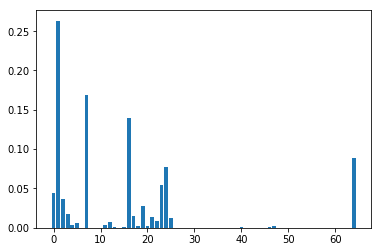

In [42]:
#print(xgb_model_fit.feature_importances_)

#plt.bar(range(len(xgb_model_fit.feature_importances_)), xgb_model_fit.feature_importances_)
#plt.show();

In [26]:
feature_importance = np.array([  4.42460328e-02,   2.63293654e-01,   3.65079381e-02,
         1.70634929e-02,   3.37301590e-03,   6.15079375e-03,
         1.98412701e-04,   1.68452382e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.96825420e-03,
         7.93650839e-03,   9.92063549e-04,   0.00000000e+00,
         1.19047624e-03,   1.39484122e-01,   1.44841271e-02,
         2.38095247e-03,   2.73809526e-02,   2.77777785e-03,
         1.34920636e-02,   8.53174645e-03,   5.49603179e-02,
         7.71825388e-02,   1.30952382e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.98412701e-04,   1.98412701e-04,   0.00000000e+00,
         0.00000000e+00,   7.93650805e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.95238118e-04,   2.18253979e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.98412701e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.86904746e-02])

In [27]:
important_features = pd.DataFrame(columns = ['feature', 'importance'])
for index, importance in enumerate(feature_importance):
    if importance >= 1e-5:
         important_features.loc[index] = [X.columns[index], importance]
important_features.sort_values('importance', inplace = True, ascending = False)
important_features.reset_index(drop = True, inplace = True)

In [28]:
important_features.shape

(29, 2)

### Tuning Parameters

In [29]:
cols = list(important_features['feature'])
cols.extend(['eval_set', 'user_id', 'product_id', 'y'])
important_train_df = train_df[cols]

In [30]:
important_train_df.user_id.nunique()

131209

In [31]:
random.seed(806)
random_users = random.sample(set(important_train_df.user_id), 10000)

In [32]:
sample_impt_train_df = important_train_df[important_train_df.user_id.isin(random_users)]

In [33]:
def new_f1_score(df):
    TNdf = pd.DataFrame(df[(df.y == 0) & (df.XGB_pred_y == 0)].groupby('user_id')['product_id'].nunique())
    TNdf.rename(columns = {'product_id': 'TN'}, inplace = True)
    TNdf.reset_index(inplace = True)
    
    TPdf = pd.DataFrame(df[(df.y == 1) & (df.XGB_pred_y == 1)].groupby('user_id')['product_id'].nunique())
    TPdf.rename(columns = {'product_id': 'TP'}, inplace = True)
    TPdf.reset_index(inplace = True)
    
    FNdf = pd.DataFrame(df[(df.y == 1) & (df.XGB_pred_y == 0)].groupby('user_id')['product_id'].nunique())
    FNdf.rename(columns = {'product_id': 'FN'}, inplace = True)
    FNdf.reset_index(inplace = True)
    
    FPdf = pd.DataFrame(df[(df.y == 0) & (df.XGB_pred_y == 1)].groupby('user_id')['product_id'].nunique())
    FPdf.rename(columns = {'product_id': 'FP'}, inplace = True)
    FPdf.reset_index(inplace = True)
    
    matrix_df = pd.merge(TNdf, TPdf, on = 'user_id', how = 'outer')
    matrix_df = pd.merge(matrix_df, FNdf, on = 'user_id', how = 'outer')
    matrix_df = pd.merge(matrix_df, FPdf, on = 'user_id', how = 'outer')
    
    matrix_df.fillna(0, inplace = True)
    matrix_df['precision'] = matrix_df.TP / (matrix_df.FP + matrix_df.TP)
    matrix_df['recall'] = matrix_df.TP / (matrix_df.FN + matrix_df.TP)
    matrix_df['f1'] = 2*matrix_df.TP / (2*matrix_df.TP+matrix_df.FP+matrix_df.FN)
    matrix_df.fillna(1, inplace = True)
    return matrix_df.f1.mean()

In [34]:
def man_cross_val(masterdf, learning_rate=0.2, max_depth=6, n_estimators=100, gamma=0, min_child_weight=1, subsample=1, threshold=0.2):
    X = masterdf.drop(['eval_set', 'user_id', 'product_id', 'y'], axis = 1)
    y = masterdf.y
    kf = GroupKFold(n_splits=5)
    final_df = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kf.split(masterdf, groups=masterdf['user_id'].values)):
        xgb_model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample)
        xgb_fit = xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
        result = xgb_fit.predict_proba(X.iloc[test_index])
        new_df = masterdf.iloc[test_index][['y', 'user_id', 'product_id']]
        new_df['True'] = result[:, 1:]
        new_df['set'] = i
        final_df = pd.concat([final_df, new_df])
    return final_df

In [35]:
def optimize_threshold(result_df, threshold_list=[0.2]):
    threshold_opt = 0.2
    max_score = 0
    for threshold in threshold_list:
        scores = []
        bins = [0, threshold, 1]
        group_names = [0, 1]
        result_df['XGB_pred_y'] = pd.cut(result_df['True'], bins, labels=group_names).astype(np.float32)
        for i in range(5):
            scores.append(new_f1_score(result_df[result_df.set == i]))
        score = np.mean(scores)
        #print(threshold, score)
        if score > max_score:
            max_score = score
            threshold_opt = threshold
    return threshold_opt, max_score

In [36]:
def tune_para_xgb(masterdf, learning_rate_list=[0.2], max_depth_list=[6], n_estimators_list=[100], gamma_list=[0], min_child_weight_list=[1], subsample_list=[1], threshold_list=[0.2]):
    max_score = 0
    parameters = [0.2, 6, 100, 0, 1, 1, 0.2]
    cols = ['learning_rate', 'max_depth', 'n_estimators', 'gamma', 'min_child_weight_list', 'subsapmle', 'opt_threshold', 'score']
    parameter_df = pd.DataFrame(columns = cols)
    for lr in learning_rate_list:
        for md in max_depth_list:
            for n in n_estimators_list:
                for g in gamma_list:
                    for w in min_child_weight_list:
                        for s in subsample_list:
                            print(lr, md, n, g, w, s)
                            sys.stdout.flush()
                            temp = optimize_threshold(man_cross_val(masterdf, learning_rate=lr, max_depth=md, n_estimators=n, gamma=g, min_child_weight=w, subsample=s), threshold_list=threshold_list)
                            score = temp[1]
                            threshold_opt = temp[0]
                            parameter_df = parameter_df.append(pd.DataFrame([[lr, md, n, g, w, s, threshold_opt, score]], columns=cols))
                            print(score, threshold_opt)
                            sys.stdout.flush()
                            if score > max_score:
                                max_score = score
                                parameters = [lr, md, n, g, w, s, threshold_opt]
    return max_score, parameters, parameter_df

In [38]:
learning_rate_list = np.arange(0.05,0.25,0.02)
max_depth_list = [3, 6, 9]
n_estimators_list = np.arange(40,100,20)
gamma_list = [0]
min_child_weight_list = [1, 3]
threshold_list = np.arange(0.1,0.4,0.001)
subsample_list = [0.8, 1]

In [39]:
import copy
masterdf = copy.deepcopy(sample_impt_train_df )

In [40]:
import sys

orig_stdout = sys.stdout
f = open('out.txt', 'w')
sys.stdout = f

In [ ]:
parameter_optimize_result = tune_para_xgb(masterdf, learning_rate_list=learning_rate_list, max_depth_list=max_depth_list, n_estimators_list=n_estimators_list, gamma_list=gamma_list, min_child_weight_list=min_child_weight_list, subsample_list = subsample_list, threshold_list=threshold_list)

In [49]:
parameter_optimize_result[2]

,learning_rate,max_depth,n_estimators,gamma,min_child_weight_list,subsapmle,opt_threshold,score
0,0.05,3,40,0,1,0.8,0.213,0.350278
0,0.05,3,40,0,1,1.0,0.211,0.350582
0,0.05,3,40,0,3,0.8,0.213,0.350278
0,0.05,3,40,0,3,1.0,0.211,0.350582
0,0.05,3,60,0,1,0.8,0.180,0.352321
0,0.05,3,60,0,1,1.0,0.189,0.352670
0,0.05,3,60,0,3,0.8,0.180,0.352321
0,0.05,3,60,0,3,1.0,0.189,0.352670
0,0.05,3,80,0,1,0.8,0.162,0.354380
0,0.05,3,80,0,1,1.0,0.166,0.354015


In [ ]:
pickle.dump(parameter_optimize_result, open('parameter_optimize_result.p', 'wb'))

## Prediction

In [50]:
lr = parameter_optimize_result[1][0]
md = parameter_optimize_result[1][1]
n = parameter_optimize_result[1][2]
g = parameter_optimize_result[1][3]
w = parameter_optimize_result[1][4]
s = parameter_optimize_result[1][5]
threshold = parameter_optimize_result[1][6]

In [51]:
print(lr, md, n, g, w, s, threshold)

In [57]:
X = important_train_df.drop(['eval_set', 'user_id', 'product_id', 'y'], axis = 1)

In [59]:
y = important_train_df.y

In [60]:
xgb_optimized_model = XGBClassifier(learning_rate=lr, max_depth=md, n_estimators=n, gamma=g, min_child_weight=w, subsample=s)

In [61]:
xgb_optimized_fit = xgb_optimized_model.fit(X,y)

In [62]:
test_users = orders[orders.eval_set == 'test'].user_id

In [68]:
test_df = master_prior_df[master_prior_df.user_id.isin(test_users)]

In [69]:
test_df = pd.merge(test_df, orders[orders.eval_set == 'test'], on='user_id', how = 'left')

In [70]:
test_df = pd.merge(test_df, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [71]:
test_df.drop('reordered', axis = 1, inplace = True)

In [92]:
cols = list(important_features['feature'])
cols.extend(['eval_set', 'user_id', 'product_id', 'order_id'])
important_test_df = copy.deepcopy(test_df[cols])

In [93]:
important_test_df.shape

(4833292, 33)

In [94]:
X_test = important_test_df.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)

In [95]:
X_test.shape

(4833292, 29)

In [96]:
important_test_df['True'] = xgb_optimized_fit.predict_proba(X_test)[:,1:]

In [97]:
bins = [0, threshold, 1]
group_names = [0, 1]

In [98]:
important_test_df['XGB_pred_y'] = pd.cut(important_test_df['True'], bins, labels=group_names)

In [99]:
important_test_df.order_id.nunique()

75000

In [100]:
important_test_df.head()

,user_product_last_purchase_day,user_product_reorder_ratio,user_history,days_since_prior_order,product_reorder_user_ratio,product_reorder_ratio,user_product_order_num,user_product_order_interval_mean,product_order_interval_mean,user_product_order_interval_std,product_user_num,product_reorder_num,product_add_to_cart_order_mean,product_reorder_user_num,user_order_interval_mean,user_product_add_order_mean,user_order_num,user_product_rank,product_order_interval_std,product_order_num,aisle_user_reorder_ratio,user_basket_size_std,user_order_interval_std,aisle_prod_reorder_num_std,aisle_reorder_ratio,aisle_prod_order_interval_mean_mean,aisle_prod_order_interval_mean_std,department_prod_order_num_sum,user_product_add_order_std,eval_set,user_id,product_id,order_id,True,XGB_pred_y
0,9,0.083333,133,11.0,0.279508,0.400251,1,42.677544,46.417255,25.335363,3821,2550.0,10.620782,1068.0,12.090909,3.000000,12,26.5,50.716755,6371,0.339986,2.103388,5.375026,845.712074,0.519170,31.982382,18.959030,2887550,4.219923,test,3,248,2774568,0.023520,0
1,107,0.083333,133,11.0,0.312741,0.440605,1,42.677544,41.313725,25.335363,259,204.0,9.498920,81.0,12.090909,5.000000,12,26.5,45.692371,463,0.327571,2.103388,5.375026,356.875358,0.527615,36.561707,21.398149,2690129,4.219923,test,3,1005,2774568,0.048090,0
2,76,0.250000,133,11.0,0.346872,0.492162,3,13.000000,34.731770,8.485281,1231,1193.0,9.287541,427.0,12.090909,2.666667,12,10.0,42.123444,2424,0.343380,2.103388,5.375026,1057.015871,0.487633,42.612740,22.806234,1875577,2.081666,test,3,1819,2774568,0.106044,0
3,30,0.083333,133,11.0,0.383731,0.553551,1,42.677544,35.672268,25.335363,5569,6905.0,9.547379,2137.0,12.090909,6.000000,12,26.5,40.877598,12474,0.339986,2.103388,5.375026,845.712074,0.519170,31.982382,18.959030,2887550,4.219923,test,3,7503,2774568,0.033859,0
4,9,0.083333,133,11.0,0.440836,0.591157,1,42.677544,39.763054,25.335363,11392,16472.0,8.822854,5022.0,12.090909,5.000000,12,26.5,40.347542,27864,0.379718,2.103388,5.375026,1222.160938,0.528005,38.155159,13.827178,738666,4.219923,test,3,8021,2774568,0.042136,0


In [101]:
result = important_test_df[important_test_df.XGB_pred_y == 1][['order_id', 'product_id']].reset_index(drop = True)

In [102]:
submission = pd.DataFrame(result.groupby('order_id').aggregate(lambda x: tuple(x)), columns = ['product_id']).reset_index()

In [103]:
submission['products'] = submission.product_id.apply(lambda x: ' '.join([str(a) for a in x]))

In [104]:
submission.drop('product_id', axis = 1, inplace=True)

In [105]:
submission.head()

,order_id,products
0,17,13107 21463 38777
1,34,2596 13176 16083 18618 21137 21463 39180 39475...
2,137,2326 5134 21903 23794 24852 25890 38689 41787
3,182,5479 9337 11520 13629 27104 32109 33000 39275 ...
4,257,21137 24852 27104 27966 29837 30233 37646 3947...


In [106]:
new_submission = pd.merge(orders[orders.eval_set == 'test'], submission, on = 'order_id', how = 'left')

In [107]:
new_submission = new_submission[['order_id', 'products']]

In [108]:
new_submission = new_submission.sort_values('order_id').reset_index(drop =True)

In [109]:
new_submission.to_csv('submission.csv', index=False)

In [110]:
new_submission.shape

(75000, 2)